<a href="https://colab.research.google.com/github/Vineesha2005/B-14_1873_PDS/blob/main/project%20codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# ---------- Minimal, defensive preprocessing for drought indices ----------
# Put this in Google Colab and run. It intentionally avoids sklearn and model training.
# It focuses only on safe data cleaning, SPI/SPEI calculation, and labeling.

import os, re, sys, traceback
from datetime import datetime
import numpy as np
import pandas as pd

# CONFIG
DATA_PATH = "/content/climate_change_impact_on_agriculture_2024.csv"
OUTPUT_DIR = "drought_preprocessed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

EPS = 1e-9  # avoid division by zero in rolling std

# Helpers
def col_like(df, patterns):
    lower_map = {c.lower(): c for c in df.columns}
    for p in patterns:
        rx = re.compile(p)
        for lc, orig in lower_map.items():
            if rx.search(lc):
                return orig
    return None

def safe_load_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found at {path}. Upload the CSV to that path.")
    df = pd.read_csv(path, low_memory=False)
    return df

def safe_dates(df):
    """
    Return a pd.Series of safe datetimes (no OutOfBounds).
    Preferences:
      1) existing 'date'/'datetime'/'timestamp' column (coerced, invalid -> NaT)
      2) year+month columns if present (clip years to [1900,2100])
      3) fallback synthetic monthly timeline starting 2000-01-01
    """
    date_col = col_like(df, [r"\bdate\b", r"datetime", r"timestamp"])
    if date_col:
        s = pd.to_datetime(df[date_col], errors="coerce")
        # mask unrealistic years
        try:
            bad = (s.dt.year < 1900) | (s.dt.year > 2100)
            if bad.any():
                s = s.mask(bad)
        except Exception:
            s = pd.to_datetime(df[date_col], errors="coerce")  # already coerced; keep
        fallback = pd.date_range("2000-01-01", periods=len(df), freq="MS")
        s = s.fillna(pd.Series(fallback, index=df.index))
        return s

    # year + month approach
    ycol = col_like(df, [r"\byear\b"])
    mcol = col_like(df, [r"\bmonth\b", r"\bmon\b"])
    if ycol and mcol:
        years = pd.to_numeric(df[ycol], errors="coerce").clip(1900, 2100).fillna(2000).astype(int)
        months = pd.to_numeric(df[mcol], errors="coerce").clip(1,12).fillna(1).astype(int)
        s = pd.to_datetime(dict(year=years, month=months, day=1), errors="coerce")
        fallback = pd.date_range("2000-01-01", periods=len(df), freq="MS")
        s = s.fillna(pd.Series(fallback, index=df.index))
        return s

    # fallback synthetic
    fallback = pd.date_range("2000-01-01", periods=len(df), freq="MS")
    return pd.Series(fallback, index=df.index)

def to_numeric_fill(df, cols, fill=0.0):
    for c in cols:
        if c and c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(fill)
    return df

def thornthwaite_pet(temp_series):
    """
    Simple Thornthwaite-like monthly PET approx.
    Uses safe operations; returns Series aligned with input.
    """
    t = temp_series.fillna(0.0).astype(float)
    tpos = np.maximum(t,0)/5.0
    tpow = np.power(tpos, 1.514)
    I = pd.Series(tpow).rolling(12, min_periods=3).sum()
    I_safe = I.clip(lower=0.1)
    a = 6.75e-7*(I_safe**3) - 7.71e-5*(I_safe**2) + 1.792e-2*I_safe + 0.49239
    ratio = (10 * (np.maximum(t,0) / I_safe)).clip(1e-6, 1e6)
    pet = 16.0 * (ratio ** a)
    pet = pd.Series(pet, index=temp_series.index).replace([np.inf, -np.inf], 0.0).fillna(0.0)
    return pet

def rolling_zsafe(series, window=3):
    # rolling mean and std with safe min_periods and EPS
    rmean = series.rolling(window, min_periods=1).mean()
    rstd = series.rolling(window, min_periods=1).std(ddof=0).fillna(0.0)
    rstd_safe = rstd + EPS
    z = (series - rmean) / rstd_safe
    z = z.replace([np.inf, -np.inf], 0.0).fillna(0.0)
    return z

# Main defensive pipeline
try:
    print("Loading CSV:", DATA_PATH)
    df = safe_load_csv(DATA_PATH)
    print("Loaded. Shape:", df.shape)
    print("Columns detected:", df.columns.tolist()[:50])

    # detect important columns (very permissive)
    rain_col = col_like(df, [r"rain", r"precip", r"ppt", r"rainfall"])
    temp_col = col_like(df, [r"temp", r"temperature", r"tmean"])
    pet_col  = col_like(df, [r"pet", r"et0", r"evapo", r"evapotransp"])
    print("Detected columns -> rain:", rain_col, " temp:", temp_col, " pet:", pet_col)

    if rain_col is None:
        raise RuntimeError("Could not find rainfall/precipitation column. Please ensure a column name contains 'rain' or 'precip'.")

    # Safe date column
    df['date'] = safe_dates(df)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    if df['date'].isna().any():
        # fill any remaining NaT with synthetic monthly timeline
        fallback = pd.date_range("2000-01-01", periods=len(df), freq="MS")
        df['date'] = df['date'].fillna(pd.Series(fallback, index=df.index))
    df = df.sort_values('date').reset_index(drop=True)

    # convert numeric columns safely
    df = to_numeric_fill(df, [rain_col, temp_col, pet_col], fill=0.0)

    # Compute PET if needed
    if (pet_col is None) and (temp_col in df.columns):
        df['_pet_est'] = thornthwaite_pet(df[temp_col])
        pet_used = '_pet_est'
    elif pet_col in df.columns:
        pet_used = pet_col
    else:
        pet_used = None

    # Compute SPI_3 and SPEI_3 safely
    try:
        df['SPI_3'] = rolling_zsafe(df[rain_col], window=3)
        if pet_used:
            df['SPEI_3'] = rolling_zsafe(df[rain_col] - df[pet_used], window=3)
        else:
            df['SPEI_3'] = df['SPI_3']  # fallback: SPEI same as SPI when no PET
    except Exception as e:
        print("Warning: SPI/SPEI calculation failed with:", e)
        df['SPI_3'] = 0.0
        df['SPEI_3'] = 0.0

    # Label drought severity (conservative: min(SPI, SPEI))
    def label_fn(row):
        v = min(row.get('SPI_3', 0.0), row.get('SPEI_3', 0.0))
        idx = np.digitize([v], [-np.inf, -2.0, -1.5, -1.0, np.inf])[0] - 1
        labels = ["Severe", "Moderate", "Mild", "Normal"]
        return labels[int(np.clip(idx, 0, 3))]
    df['drought_severity'] = df.apply(label_fn, axis=1)

    # Diagnostics
    print("\nSample of processed data (first 8 rows):")
    cols_show = ['date', rain_col, temp_col, pet_used if pet_used else pet_col, 'SPI_3', 'SPEI_3', 'drought_severity']
    cols_show = [c for c in cols_show if c and c in df.columns]
    print(df[cols_show].head(8).to_string(index=False))
    print("\nDrought class counts:\n", df['drought_severity'].value_counts())

    # Save processed CSV
    out_name = f"preprocessed_drought_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    out_path = os.path.join(OUTPUT_DIR, out_name)
    df.to_csv(out_path, index=False)
    print("\nSaved cleaned & labeled dataset to:", out_path)
    print("If this completes without an exception, we can proceed to safe model training using this file.")

except Exception as exc:
    print("Fatal error during preprocessing (caught). Details:")
    traceback.print_exc()
    # try to save partial data if exists
    try:
        tmp_path = os.path.join(OUTPUT_DIR, "preprocessed_partial.csv")
        df.to_csv(tmp_path, index=False)
        print("Saved partial output to", tmp_path)
    except Exception:
        pass
    # do not re-raise; user asked for "no errors"
    print("Preprocessing ended with errors. Paste the printed traceback above so I can fix the exact failing step.")


Loading CSV: /content/climate_change_impact_on_agriculture_2024.csv
Loaded. Shape: (10000, 15)
Columns detected: ['Year', 'Country', 'Region', 'Crop_Type', 'Average_Temperature_C', 'Total_Precipitation_mm', 'CO2_Emissions_MT', 'Crop_Yield_MT_per_HA', 'Extreme_Weather_Events', 'Irrigation_Access_%', 'Pesticide_Use_KG_per_HA', 'Fertilizer_Use_KG_per_HA', 'Soil_Health_Index', 'Adaptation_Strategies', 'Economic_Impact_Million_USD']
Detected columns -> rain: Total_Precipitation_mm  temp: Average_Temperature_C  pet: None
Fatal error during preprocessing (caught). Details:
Saved partial output to drought_preprocessed/preprocessed_partial.csv
Preprocessing ended with errors. Paste the printed traceback above so I can fix the exact failing step.


Traceback (most recent call last):
  File "timestamps.pyx", line 2476, in pandas._libs.tslibs.timestamps.Timestamp.replace
OverflowError: Overflow occurred in npy_datetimestruct_to_datetime

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-4187869594.py", line 118, in <cell line: 0>
    df['date'] = safe_dates(df)
                 ^^^^^^^^^^^^^^
  File "/tmp/ipython-input-4187869594.py", line 67, in safe_dates
    fallback = pd.date_range("2000-01-01", periods=len(df), freq="MS")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/datetimes.py", line 1008, in date_range
    dtarr = DatetimeArray._generate_range(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/arrays/datetimes.py", line 468, in _generate_range
    i8values = np.array([x._value for x in xdr], dtype=n

In [11]:
import os, re, traceback
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# ---------------- CONFIG ----------------
DATA_PATH = "/content/climate_change_impact_on_agriculture_2024.csv"
OUTDIR = "unsupervised_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# ---------------- HELPERS ----------------
def col_like(df, patterns):
    lc_map = {c.lower(): c for c in df.columns}
    for pat in patterns:
        rx = re.compile(pat)
        for lc, orig in lc_map.items():
            if rx.search(lc):
                return orig
    return None

def safe_dates(df):
    """Robustly parse dates without OutOfBoundsDatetime"""
    dcol = col_like(df, [r"date", r"timestamp", r"datetime"])
    if dcol:
        s = pd.to_datetime(df[dcol], errors="coerce")
        # Handle invalid years: clip 1900–2100
        mask_bad = (s.dt.year < 1900) | (s.dt.year > 2100)
        if mask_bad.any():
            s[mask_bad] = pd.NaT
        fallback = pd.date_range("2000-01-01", periods=len(df), freq="MS")
        return s.fillna(pd.Series(fallback, index=df.index))

    # Year + Month fallback
    ycol = col_like(df, ["year"])
    mcol = col_like(df, ["month"])
    if ycol:
        y = pd.to_numeric(df[ycol], errors="coerce").clip(1900, 2100).fillna(2000).astype(int)
        m = pd.to_numeric(df[mcol], errors="coerce").clip(1,12).fillna(1).astype(int) if mcol else 1
        s = pd.to_datetime(dict(year=y, month=m, day=1), errors="coerce")
        fallback = pd.date_range("2000-01-01", periods=len(df), freq="MS")
        return s.fillna(pd.Series(fallback, index=df.index))

    # Pure synthetic timeline
    return pd.date_range("2000-01-01", periods=len(df), freq="MS").to_series(index=df.index)

def rolling_z(series, window=3):
    rm = series.rolling(window, min_periods=1).mean()
    rsd = series.rolling(window, min_periods=1).std(ddof=0).fillna(0.0)
    z = (series - rm) / (rsd + 1e-9)
    return z.replace([np.inf, -np.inf], 0.0).fillna(0.0)

# ---------------- MAIN ----------------
try:
    # Load dataset
    df = pd.read_csv(DATA_PATH)
    print("Dataset loaded:", df.shape)

    # Identify columns
    rain_col = col_like(df, ["rain", "precip", "ppt", "rainfall"])
    temp_col = col_like(df, ["temp", "temperature"])
    pet_col  = col_like(df, ["pet", "evapo"])
    region_col = col_like(df, ["region", "state", "district"])
    print("Detected columns:", rain_col, temp_col, pet_col)

    if rain_col is None:
        raise RuntimeError("Rain column is required but not found in dataset.")

    # Safe date parsing
    df["date"] = safe_dates(df)
    df = df.sort_values("date").reset_index(drop=True)

    # Numeric coercion for rain/temp/pet
    for col in [rain_col, temp_col, pet_col]:
        if col and col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0.0)

    # SPI & SPEI calculation
    rain = df[rain_col]
    temp = df[temp_col] if temp_col else pd.Series(0, index=df.index)
    pet  = df[pet_col] if pet_col else pd.Series(0, index=df.index)
    df["SPI_3"] = rolling_z(rain, 3)
    df["SPEI_3"] = rolling_z(rain - pet, 3)

    # Select features for unsupervised learning
    features = [rain_col, temp_col, pet_col, "SPI_3", "SPEI_3"]
    features = [f for f in features if f]
    X = df[features].fillna(0.0)

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Run PCA for visualization
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    pca_df.to_csv(os.path.join(OUTDIR, "pca_projection.csv"), index=False)

    # Define algorithms
    algorithms = {
        "KMeans_k3": KMeans(n_clusters=3, random_state=42),
        "KMeans_k4": KMeans(n_clusters=4, random_state=42),
        "GMM_k3": GaussianMixture(n_components=3, random_state=42),
        "GMM_k4": GaussianMixture(n_components=4, random_state=42),
        "Agglomerative": AgglomerativeClustering(n_clusters=3),
        "DBSCAN": DBSCAN(eps=1.0, min_samples=5),
    }

    results = []
    for name, model in algorithms.items():
        try:
            print(f"\nRunning {name}...")
            if isinstance(model, GaussianMixture):
                model.fit(X_scaled)
                labels = model.predict(X_scaled)
            else:
                labels = model.fit_predict(X_scaled)

            df[f"Cluster_{name}"] = labels

            # Calculate silhouette score if possible
            score = silhouette_score(X_scaled, labels) if len(set(labels)) > 1 else np.nan
            results.append({"Algorithm": name, "Silhouette": score})
            print(f"{name} completed. Silhouette: {score}")
        except Exception as e:
            print(f"{name} failed -> {e}")
            results.append({"Algorithm": name, "Silhouette": None})

    # Save results
    score_df = pd.DataFrame(results)
    score_df.to_csv(os.path.join(OUTDIR, "unsupervised_results.csv"), index=False)
    df.to_csv(os.path.join(OUTDIR, "processed_with_clusters.csv"), index=False)
    print("\nAll results saved in:", OUTDIR)

except Exception as e:
    print("Pipeline crashed:", e)
    traceback.print_exc()


Dataset loaded: (10000, 15)
Detected columns: Total_Precipitation_mm Average_Temperature_C None
Pipeline crashed: Out of bounds timestamp: 2833-04-01 00:00:00 with frequency 'ns'


Traceback (most recent call last):
  File "timestamps.pyx", line 2476, in pandas._libs.tslibs.timestamps.Timestamp.replace
OverflowError: Overflow occurred in npy_datetimestruct_to_datetime

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-682989385.py", line 76, in <cell line: 0>
    df["date"] = safe_dates(df)
                 ^^^^^^^^^^^^^^
  File "/tmp/ipython-input-682989385.py", line 47, in safe_dates
    fallback = pd.date_range("2000-01-01", periods=len(df), freq="MS")
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/datetimes.py", line 1008, in date_range
    dtarr = DatetimeArray._generate_range(
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/core/arrays/datetimes.py", line 468, in _generate_range
    i8values = np.array([x._value for x in xdr], dtype=np.i

In [15]:
!pip install gymnasium==0.29.1
!pip install stable-baselines3==2.3.0
!pip install shimmy==1.2.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.0
    Uninstalling gymnasium-1.2.0:
      Successfully uninstalled gymnasium-1.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


Reason for being yanked: Loading broken with PyTorch 1.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 3.5 MB/s eta 0:00:00


In [16]:
import os, warnings, random
import numpy as np
import pandas as pd
import traceback

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, A2C, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

warnings.filterwarnings("ignore")
os.makedirs("rl_models", exist_ok=True)

# --------------------------
# Load & Prepare Dataset
# --------------------------
DATA_PATH = "/content/climate_change_impact_on_agriculture_2024.csv"

def col_like(df, patterns):
    import re
    cols = {c.lower(): c for c in df.columns}
    for p in patterns:
        rx = re.compile(p)
        for lc, orig in cols.items():
            if rx.search(lc):
                return orig
    return None

def safe_load_and_prepare(path):
    df = pd.read_csv(path, low_memory=False)

    # Find relevant columns
    rain_col = col_like(df, [r"rain", r"precip", r"ppt", r"rainfall"])
    temp_col = col_like(df, [r"temp", r"temperature"])
    pet_col  = col_like(df, [r"pet", r"et0", r"evapo", r"evapotransp"])
    soil_col = col_like(df, [r"soil", r"soil_moist", r"sm"])

    # Sort by date if exists
    date_col = col_like(df, [r"date", r"datetime", r"timestamp"])
    if date_col:
        df['date'] = pd.to_datetime(df[date_col], errors='coerce')
        df = df.sort_values('date').reset_index(drop=True)
    else:
        df = df.reset_index(drop=True)

    # Convert numeric columns
    for c in [rain_col, temp_col, pet_col, soil_col]:
        if c and c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    # Compute SPI & SPEI if missing
    def rolling_z(s, w=3):
        s = s.fillna(0.0).astype(float)
        m = s.rolling(w, min_periods=1).mean()
        sd = s.rolling(w, min_periods=1).std(ddof=0).fillna(0.0)
        return ((s - m) / (sd + 1e-9)).fillna(0.0)

    if 'SPI_3' not in df.columns and rain_col:
        df['SPI_3'] = rolling_z(df[rain_col])
    if 'SPEI_3' not in df.columns and rain_col:
        pet_series = df[pet_col] if pet_col else 0.0
        df['SPEI_3'] = rolling_z(df[rain_col] - pet_series)

    if not soil_col:
        df['soil_moist'] = df[rain_col].rolling(3, min_periods=1).sum().fillna(0.0)
        soil_col = 'soil_moist'

    features = [soil_col, 'SPI_3', 'SPEI_3']
    if rain_col: features.append(rain_col)
    if temp_col: features.append(temp_col)

    df.fillna(0.0, inplace=True)
    meta = {'features': features, 'rain_col': rain_col, 'pet_col': pet_col}
    return df, meta

df, meta = safe_load_and_prepare(DATA_PATH)
print("✅ Dataset Loaded | Features used:", meta['features'])

# --------------------------
# Gymnasium RL Environment
# --------------------------
class DroughtIrrigationEnv(gym.Env):
    metadata = {'render_modes': ['human']}

    def __init__(self, df, features, max_steps=120):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.features = features
        self.max_steps = max_steps

        # Actions: 0=no irrigation, 1=low, 2=medium, 3=high
        self.action_map = {0: 0.0, 1: 5.0, 2: 10.0, 3: 20.0}
        self.action_space = spaces.Discrete(len(self.action_map))

        # Observations: climate features + soil moisture + last action
        obs_dim = len(self.features) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = random.randint(0, len(self.df) - 1)
        self.steps = 0
        self.soil_moist = float(self.df.iloc[self.current_step].get('soil_moist', 10.0))
        return self._get_obs(), {}

    def step(self, action):
        row = self.df.iloc[self.current_step]
        irr = self.action_map[int(action)]

        rain = float(row.get(meta['rain_col'], 0.0)) if meta['rain_col'] else 0.0
        pet = float(row.get(meta['pet_col'], 0.0)) if meta['pet_col'] else 0.0
        self.soil_moist = max(0.0, min(100.0, self.soil_moist + rain + irr - pet))

        # Reward calculation
        opt_low, opt_high = 30.0, 70.0
        crop_health = 1.0 if opt_low <= self.soil_moist <= opt_high else max(0.0, 1.0 - abs(self.soil_moist - 50) / 50)
        drought_penalty = 0.2 if float(row['SPI_3']) < -1.5 else 0.0
        reward = crop_health - 0.01 * irr - drought_penalty

        self.current_step += 1
        self.steps += 1
        done = self.steps >= self.max_steps or self.current_step >= len(self.df) - 1

        return self._get_obs(), reward, done, False, {}

    def _get_obs(self):
        row = self.df.iloc[self.current_step]
        feats = np.array([float(row.get(f, 0.0)) for f in self.features], dtype=np.float32)
        return np.concatenate([feats, [self.soil_moist / 100.0, 0.0]]).astype(np.float32)

# --------------------------
# Train PPO, A2C, DQN
# --------------------------
env = DummyVecEnv([lambda: DroughtIrrigationEnv(df, meta['features'])])
models = {}
train_steps = 5000

# PPO Training
try:
    models['PPO'] = PPO("MlpPolicy", env, verbose=0)
    models['PPO'].learn(total_timesteps=train_steps)
    print("✅ PPO Trained")
except Exception as e:
    print("❌ PPO Failed:", e)
    traceback.print_exc()

# A2C Training
try:
    models['A2C'] = A2C("MlpPolicy", env, verbose=0)
    models['A2C'].learn(total_timesteps=train_steps)
    print("✅ A2C Trained")
except Exception as e:
    print("❌ A2C Failed:", e)
    traceback.print_exc()

# DQN Training
try:
    dqn_env = DummyVecEnv([lambda: DroughtIrrigationEnv(df, meta['features'])])
    models['DQN'] = DQN("MlpPolicy", dqn_env, verbose=0)
    models['DQN'].learn(total_timesteps=train_steps)
    print("✅ DQN Trained")
except Exception as e:
    print("❌ DQN Failed:", e)
    traceback.print_exc()

# --------------------------
# Evaluate the Models
# --------------------------
print("\n📊 Model Evaluation Results:")
for name, model in models.items():
    eval_env = DroughtIrrigationEnv(df, meta['features'])
    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=5)
    print(f"{name} → Mean Reward = {mean_reward:.3f}, Std = {std_reward:.3f}")


✅ Dataset Loaded | Features used: ['Soil_Health_Index', 'SPI_3', 'SPEI_3', 'Total_Precipitation_mm', 'Average_Temperature_C']
✅ PPO Trained
✅ A2C Trained
✅ DQN Trained

📊 Model Evaluation Results:
PPO → Mean Reward = 0.000, Std = 0.000
A2C → Mean Reward = 0.000, Std = 0.000
DQN → Mean Reward = -10.280, Std = 0.256


In [20]:
# Robust Deep Learning Suite for Drought Modeling (NO datetime parsing)
# - Uses the CSV row order as time order (sliding windows for sequences)
# - Handles missing PET / NDVI gracefully
# - Trains MLP, CNN1D, LSTM, GRU, Transformer encoder, Autoencoder
# - Path: /content/climate_change_impact_on_agriculture_2024.csv

import os, re, traceback
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# ------------- CONFIG -------------
DATA_PATH = "/content/climate_change_impact_on_agriculture_2024.csv"
OUTDIR = "dl_models_safe"
os.makedirs(OUTDIR, exist_ok=True)

SEQ_LEN = 12          # sliding window length for sequence models
BATCH_SIZE = 32
EPOCHS = 12           # small default for quick runs; increase for better results
LR = 1e-3
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ------------- HELPERS -------------
def col_like(df, patterns):
    cols = {c.lower(): c for c in df.columns}
    for p in patterns:
        rx = re.compile(p)
        for lc, orig in cols.items():
            if rx.search(lc):
                return orig
    return None

def safe_to_numeric_fill(df, cols, fill=None):
    for c in cols:
        if c and c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
            if fill is None:
                # use median if available else 0
                med = df[c].median()
                df[c] = df[c].fillna(med if not np.isnan(med) else 0.0)
            else:
                df[c] = df[c].fillna(fill)
    return df

def rolling_zsafe(series, window=3):
    s = pd.Series(series).astype(float).copy()
    # compute rolling mean/std on positional index (no datetime needed)
    rmean = s.rolling(window, min_periods=1).mean()
    rstd = s.rolling(window, min_periods=1).std(ddof=0)
    # avoid divide-by-zero: replace zeros/nans with stable value
    if rstd.isna().all() or (rstd == 0).all():
        rstd = pd.Series(np.ones(len(s)), index=s.index)
    else:
        # replace zeros with median of non-zero std or 1
        nonzero_median = rstd[rstd > 0].median()
        if np.isnan(nonzero_median):
            nonzero_median = 1.0
        rstd = rstd.replace(0, nonzero_median).fillna(nonzero_median)
    z = (s - rmean) / (rstd + 1e-9)
    return z.fillna(0.0).values

def make_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    n = len(X)
    if n < seq_len:
        return np.zeros((0, seq_len, X.shape[1])), np.zeros((0,), dtype=int)
    for i in range(n - seq_len + 1):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1])
    return np.array(Xs), np.array(ys)

# ------------- LOAD & SANITIZE -------------
print("Loading CSV:", DATA_PATH)
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns)[:40])

# Detect columns (very permissive)
rain_col = col_like(df, [r"rain", r"precip", r"ppt", r"total_precipitation", r"precipitation"])
temp_col = col_like(df, [r"temp", r"temperature", r"average_temperature", r"tmean"])
pet_col  = col_like(df, [r"pet", r"evap", r"et0", r"evapotransp"])
soil_col = col_like(df, [r"soil", r"soil_health", r"soil_moist", r"soil_moisture", r"soilhealth"])
ndvi_col = col_like(df, [r"ndvi", r"ndvi_index", r"vegetation"])

print("Detected -> rain:", rain_col, " temp:", temp_col, " pet:", pet_col, " soil:", soil_col, " ndvi:", ndvi_col)

# We will NOT parse dates. Use row order as time order.
# Ensure numeric columns are numeric and safely filled
numeric_candidates = [rain_col, temp_col, pet_col, soil_col, ndvi_col]
df = safe_to_numeric_fill(df, numeric_candidates, fill=None)  # median fill or 0 if median NaN

# If PET missing and temperature present, estimate PET with a small Thornthwaite approximation:
def thornthwaite_pet_est(temp_series):
    t = np.maximum(temp_series.fillna(0.0).astype(float), 0.0) / 5.0
    t = np.where(np.isfinite(t), t, 0.0)
    # simple proxy: PET ≈ 0.6 * T for positive temps (very coarse) — safe and simple
    return 0.6 * temp_series.fillna(0.0).astype(float)

if (not pet_col) or (pet_col not in df.columns):
    if temp_col and temp_col in df.columns:
        print("PET not found — estimating PET from temperature (coarse proxy).")
        df['_pet_est'] = thornthwaite_pet_est(df[temp_col])
        pet_use = '_pet_est'
    else:
        print("PET and temperature both missing — using PET=0.")
        df['_pet_est'] = 0.0
        pet_use = '_pet_est'
else:
    pet_use = pet_col

# Compute SPI_3 and SPEI_3 using rolling_zsafe (positional rolling)
if not rain_col:
    raise RuntimeError("Rainfall/precipitation column not detected. Please ensure your CSV has rainfall values.")
df['SPI_3']  = rolling_zsafe(df[rain_col].values, window=3)
df['SPEI_3'] = rolling_zsafe((df[rain_col].values - df[pet_use].values), window=3)

# If soil missing, create a proxy aggregated rainfall -> soil moisture
if not soil_col:
    print("Soil column not found — computing soil_moist proxy from recent rainfall.")
    df['soil_moist'] = pd.Series(df[rain_col].fillna(0.0)).rolling(3, min_periods=1).sum().fillna(0.0).values
    soil_use = 'soil_moist'
else:
    soil_use = soil_col

# Build feature list (only numeric & available)
feature_cols = [c for c in [rain_col, temp_col, pet_use, soil_use, 'SPI_3', 'SPEI_3', ndvi_col] if c and c in df.columns]
print("Features used:", feature_cols)

# Fill any remaining NaNs with column medians / zero
for c in feature_cols:
    col_med = pd.to_numeric(df[c], errors='coerce').median()
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(col_med if not np.isnan(col_med) else 0.0)

# ------------- Create Target (Drought Severity) -------------
def drought_label_from_indices(spi, spei):
    v = min(spi, spei)
    if v <= -2.0: return "Severe"
    if v <= -1.5: return "Moderate"
    if v <= -1.0: return "Mild"
    return "Normal"

df['drought_severity'] = [drought_label_from_indices(s1, s2) for s1, s2 in zip(df['SPI_3'], df['SPEI_3'])]
print("Drought class counts:\n", df['drought_severity'].value_counts())

# ------------- Prepare Data for Models -------------
X_all = df[feature_cols].values.astype(float)
y_all = np.array(df['drought_severity'].values)

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y_all)
print("Label classes:", list(le.classes_))

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

# For sequence models create sliding windows (positional)
X_seq, y_seq = make_sequences = (lambda X, y, L=SEQ_LEN: (np.array([X[i:i+L] for i in range(len(X)-L+1)]), np.array([y[i+L-1] for i in range(len(X)-L+1)])))(X_scaled, y_enc, SEQ_LEN)
X_s, y_s = X_seq, y_seq
if X_s.shape[0] == 0:
    # fallback: not enough rows for sequences — use last-timestep approach
    print("Not enough rows to form sequences of length", SEQ_LEN, "→ sequence models will be skipped.")
    use_sequences = False
else:
    use_sequences = True
print("Sequence dataset shape:", X_s.shape if use_sequences else None)

# For non-sequence models use last-aligned samples so that we can compare fairly with sequence labels
if use_sequences:
    X_last = X_scaled[SEQ_LEN-1:]
    y_last = y_enc[SEQ_LEN-1:]
else:
    X_last = X_scaled
    y_last = y_enc

# Time-aware train/test split (no shuffling)
def time_split(X, y, frac=0.8):
    n = len(X)
    idx = max(1, int(n * frac))
    return X[:idx], X[idx:], y[:idx], y[idx:]

# split
if use_sequences:
    X_train_seq, X_test_seq, y_train_seq, y_test_seq = time_split(X_s, y_s)
else:
    X_train_seq = X_test_seq = y_train_seq = y_test_seq = None

X_train_last, X_test_last, y_train_last, y_test_last = time_split(X_last, y_last)

print("Train/test sizes (non-seq):", X_train_last.shape, X_test_last.shape)
if use_sequences:
    print("Train/test sizes (seq):", X_train_seq.shape, X_test_seq.shape)

# ------------- Build Keras Models -------------
def build_mlp(input_dim, n_classes):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(128, activation='relu')(inp)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    m = models.Model(inp, out)
    m.compile(optimizer=optimizers.Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

def build_cnn1d(seq_shape, n_classes):
    inp = layers.Input(shape=seq_shape)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    m = models.Model(inp, out)
    m.compile(optimizer=optimizers.Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

def build_lstm(seq_shape, n_classes):
    inp = layers.Input(shape=seq_shape)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inp)
    x = layers.Bidirectional(layers.LSTM(32))(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    m = models.Model(inp, out)
    m.compile(optimizer=optimizers.Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

def build_gru(seq_shape, n_classes):
    inp = layers.Input(shape=seq_shape)
    x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(inp)
    x = layers.Bidirectional(layers.GRU(32))(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    m = models.Model(inp, out)
    m.compile(optimizer=optimizers.Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

def build_transformer(seq_shape, n_classes, head_size=32, num_heads=2, ff_dim=64, num_blocks=1):
    inp = layers.Input(shape=seq_shape)
    x = inp
    for _ in range(num_blocks):
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        x1 = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(x1, x1)
        x = layers.Add()([x, x1])
        x2 = layers.LayerNormalization(epsilon=1e-6)(x)
        x2 = layers.Dense(ff_dim, activation='relu')(x2)
        x = layers.Add()([x, x2])
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    m = models.Model(inp, out)
    m.compile(optimizer=optimizers.Adam(LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

def build_autoencoder(seq_shape):
    inp = layers.Input(shape=seq_shape)
    x = layers.Conv1D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Flatten()(x)
    latent = layers.Dense(32, activation='relu')(x)
    x = layers.Dense((seq_shape[0]//4) * 16, activation='relu')(latent)
    x = layers.Reshape((seq_shape[0]//4, 16))(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(seq_shape[1], 3, activation=None, padding='same')(x)
    m = models.Model(inp, x)
    m.compile(optimizer=optimizers.Adam(LR), loss='mse')
    return m

# ------------- Train & Evaluate Models (defensive) -------------
n_classes = len(np.unique(y_enc))
trained_models = {}
reports = {}

# 1) MLP (non-sequence)
try:
    print("\nTraining MLP...")
    mlp = build_mlp(X_train_last.shape[1], n_classes)
    cb = [callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    mlp.fit(X_train_last, y_train_last, validation_split=0.15, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb, verbose=1)
    preds = np.argmax(mlp.predict(X_test_last), axis=1)
    print("MLP report:\n", classification_report(y_test_last, preds, zero_division=0, target_names=le.classes_))
    trained_models['mlp'] = mlp
    reports['mlp'] = classification_report(y_test_last, preds, output_dict=True, zero_division=0)
except Exception as e:
    print("MLP failed:", e)
    traceback.print_exc()

# sequence models only if sequences exist
if use_sequences:
    seq_shape = (X_train_seq.shape[1], X_train_seq.shape[2])

    # 2) CNN1D
    try:
        print("\nTraining CNN1D...")
        cnn = build_cnn1d(seq_shape, n_classes)
        cb = [callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
        cnn.fit(X_train_seq, y_train_seq, validation_split=0.15, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb, verbose=1)
        preds = np.argmax(cnn.predict(X_test_seq), axis=1)
        print("CNN1D report:\n", classification_report(y_test_seq, preds, zero_division=0, target_names=le.classes_))
        trained_models['cnn1d'] = cnn
        reports['cnn1d'] = classification_report(y_test_seq, preds, output_dict=True, zero_division=0)
    except Exception as e:
        print("CNN1D failed:", e)
        traceback.print_exc()

    # 3) LSTM
    try:
        print("\nTraining LSTM...")
        lstm = build_lstm(seq_shape, n_classes)
        cb = [callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
        lstm.fit(X_train_seq, y_train_seq, validation_split=0.15, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb, verbose=1)
        preds = np.argmax(lstm.predict(X_test_seq), axis=1)
        print("LSTM report:\n", classification_report(y_test_seq, preds, zero_division=0, target_names=le.classes_))
        trained_models['lstm'] = lstm
        reports['lstm'] = classification_report(y_test_seq, preds, output_dict=True, zero_division=0)
    except Exception as e:
        print("LSTM failed:", e)
        traceback.print_exc()

    # 4) GRU
    try:
        print("\nTraining GRU...")
        gru = build_gru(seq_shape, n_classes)
        cb = [callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
        gru.fit(X_train_seq, y_train_seq, validation_split=0.15, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb, verbose=1)
        preds = np.argmax(gru.predict(X_test_seq), axis=1)
        print("GRU report:\n", classification_report(y_test_seq, preds, zero_division=0, target_names=le.classes_))
        trained_models['gru'] = gru
        reports['gru'] = classification_report(y_test_seq, preds, output_dict=True, zero_division=0)
    except Exception as e:
        print("GRU failed:", e)
        traceback.print_exc()

    # 5) Transformer encoder
    try:
        print("\nTraining Transformer encoder...")
        transformer = build_transformer(seq_shape, n_classes, num_blocks=1)
        cb = [callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
        transformer.fit(X_train_seq, y_train_seq, validation_split=0.15, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb, verbose=1)
        preds = np.argmax(transformer.predict(X_test_seq), axis=1)
        print("Transformer report:\n", classification_report(y_test_seq, preds, zero_division=0, target_names=le.classes_))
        trained_models['transformer'] = transformer
        reports['transformer'] = classification_report(y_test_seq, preds, output_dict=True, zero_division=0)
    except Exception as e:
        print("Transformer failed:", e)
        traceback.print_exc()

    # 6) Autoencoder (unsupervised anomaly detection)
    try:
        print("\nTraining sequence Autoencoder...")
        ae = build_autoencoder(seq_shape)
        cb = [callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
        # train on all training sequences (alternatively: filter "Normal" sequences)
        ae.fit(X_train_seq, X_train_seq, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=cb, validation_split=0.1, verbose=1)
        recon = ae.predict(X_test_seq)
        mse = np.mean(np.square(recon - X_test_seq), axis=(1,2))
        thr = mse.mean() + 2*mse.std()
        anomalies = (mse > thr).sum()
        print(f"AE recon mse mean={mse.mean():.4f} thr={thr:.4f} anomalies={anomalies}/{len(mse)}")
        trained_models['autoencoder'] = ae
        reports['autoencoder'] = {"mse_mean": float(mse.mean()), "threshold": float(thr), "anomalies": int(anomalies)}
    except Exception as e:
        print("Autoencoder failed:", e)
        traceback.print_exc()

# ------------- Save models & scaler & label encoder -------------
import joblib
joblib.dump(scaler, os.path.join(OUTDIR, "scaler.joblib"))
joblib.dump(le, os.path.join(OUTDIR, "labelencoder.joblib"))
for name, m in trained_models.items():
    try:
        path = os.path.join(OUTDIR, f"{name}_model.keras")
        m.save(path)
        print("Saved model:", path)
    except Exception:
        try:
            # fallback for some objects that can't be saved by .save()
            wpath = os.path.join(OUTDIR, f"{name}_weights.h5")
            m.save_weights(wpath)
            print("Saved weights for:", name)
        except Exception as e:
            print("Failed to save", name, "->", e)

# ------------- Summary -------------
print("\nFinished. Models saved in:", OUTDIR)
print("Reports keys:", list(reports.keys()))
for k, v in reports.items():
    print("\nModel:", k)
    if isinstance(v, dict):
        # pretty-print classification metrics if present
        for metric, vals in v.items():
            if metric in ['accuracy','macro avg','weighted avg','micro avg','Severe','Moderate','Mild','Normal']:
                pass
    print(v)


Loading CSV: /content/climate_change_impact_on_agriculture_2024.csv
Loaded shape: (10000, 15)
Columns: ['Year', 'Country', 'Region', 'Crop_Type', 'Average_Temperature_C', 'Total_Precipitation_mm', 'CO2_Emissions_MT', 'Crop_Yield_MT_per_HA', 'Extreme_Weather_Events', 'Irrigation_Access_%', 'Pesticide_Use_KG_per_HA', 'Fertilizer_Use_KG_per_HA', 'Soil_Health_Index', 'Adaptation_Strategies', 'Economic_Impact_Million_USD']
Detected -> rain: Total_Precipitation_mm  temp: Average_Temperature_C  pet: None  soil: Soil_Health_Index  ndvi: None
PET not found — estimating PET from temperature (coarse proxy).
Features used: ['Total_Precipitation_mm', 'Average_Temperature_C', '_pet_est', 'Soil_Health_Index', 'SPI_3', 'SPEI_3']
Drought class counts:
 drought_severity
Normal    7556
Mild      2444
Name: count, dtype: int64
Label classes: ['Mild', 'Normal']
Sequence dataset shape: (9989, 12, 6)
Train/test sizes (non-seq): (7991, 6) (1998, 6)
Train/test sizes (seq): (7991, 12, 6) (1998, 12, 6)

Training

Traceback (most recent call last):
  File "/tmp/ipython-input-3890916589.py", line 349, in <cell line: 0>
    transformer = build_transformer(seq_shape, n_classes, num_blocks=1)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3890916589.py", line 255, in build_transformer
    x = layers.Add()([x, x2])
        ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/merging/base_merge.py", line 93, in _compute_elemwise_op_output_shape
    raise ValueError(
ValueError: Inputs have incompatible shapes. Received shapes (12, 6) and (12, 64)


225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9617 - val_loss: 0.8118
Epoch 2/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7726 - val_loss: 0.6811
Epoch 3/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6723 - val_loss: 0.6058
Epoch 4/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5968 - val_loss: 0.5123
Epoch 5/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5090 - val_loss: 0.4487
Epoch 6/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4577 - val_loss: 0.4228
Epoch 7/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4331 - val_loss: 0.4035
Epoch 8/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4134 - val_loss: 0.3864
Epoch 9/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3976 - val_loss: 0.3747
Epoch 10/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3872 - val_loss: 0.3661
Epoch 11/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3789 - val_loss: 0.3578
Epoch 12/12
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

In [21]:
# Ensemble ML pipeline for drought severity classification (robust, Colab-ready)
# Path expected: /content/climate_change_impact_on_agriculture_2024.csv

import os, re, traceback
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
import joblib
import warnings
warnings.filterwarnings("ignore")

OUTDIR = "ensemble_outputs"
os.makedirs(OUTDIR, exist_ok=True)

DATA_PATH = "/content/climate_change_impact_on_agriculture_2024.csv"
SEQ_LEN = 12  # not used here but kept for compatibility

# ---------------- Helpers (robust) ----------------
def col_like(df, patterns):
    cols = {c.lower(): c for c in df.columns}
    for p in patterns:
        rx = re.compile(p)
        for lc, orig in cols.items():
            if rx.search(lc):
                return orig
    return None

def safe_to_numeric_fill(df, cols, fill=None):
    for c in cols:
        if c and c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
            if fill is None:
                med = df[c].median()
                df[c] = df[c].fillna(med if not np.isnan(med) else 0.0)
            else:
                df[c] = df[c].fillna(fill)
    return df

def rolling_zsafe(arr, window=3):
    s = pd.Series(arr).astype(float)
    rmean = s.rolling(window, min_periods=1).mean()
    rstd = s.rolling(window, min_periods=1).std(ddof=0)
    if rstd.isna().all() or (rstd == 0).all():
        rstd = pd.Series(np.ones(len(s)), index=s.index)
    else:
        nonzero_median = rstd[rstd > 0].median()
        if np.isnan(nonzero_median):
            nonzero_median = 1.0
        rstd = rstd.replace(0, nonzero_median).fillna(nonzero_median)
    z = (s - rmean) / (rstd + 1e-9)
    return z.fillna(0.0).values

# ---------------- Load & sanitize ----------------
print("Loading:", DATA_PATH)
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:40])

# detect columns
rain_col  = col_like(df, [r"rain", r"precip", r"ppt", r"total_precipitation"])
temp_col  = col_like(df, [r"temp", r"temperature", r"avg_temp"])
pet_col   = col_like(df, [r"pet", r"evapo", r"et0", r"evapotransp"])
soil_col  = col_like(df, [r"soil", r"soil_health", r"soil_moist", r"soil_moisture"])
ndvi_col  = col_like(df, [r"ndvi", r"veg", r"ndvi_index"])
yield_col = col_like(df, [r"yield", r"production", r"crop"])

print("Detected -> rain:", rain_col, "temp:", temp_col, "pet:", pet_col, "soil:", soil_col, "ndvi:", ndvi_col, "yield:", yield_col)

# We will NOT parse dates to avoid OutOfBoundsDatetime; use row order as time order
numeric_candidates = [rain_col, temp_col, pet_col, soil_col, ndvi_col, yield_col]
df = safe_to_numeric_fill(df, numeric_candidates, fill=None)

# if pet missing, estimate from temp (coarse proxy) or set zero
if (not pet_col) or (pet_col not in df.columns):
    if temp_col and temp_col in df.columns:
        print("Estimating PET as 0.6 * temperature (coarse proxy).")
        df['_pet_est'] = 0.6 * df[temp_col].fillna(0.0)
        pet_use = '_pet_est'
    else:
        print("No PET or temperature; using PET=0.")
        df['_pet_est'] = 0.0
        pet_use = '_pet_est'
else:
    pet_use = pet_col

# must have rainfall
if not rain_col:
    raise RuntimeError("No rainfall/precipitation-like column found. Rename your rainfall column to include 'rain' or 'precip'.")

# compute SPI_3 and SPEI_3 safely (positional rolling)
df['SPI_3']  = rolling_zsafe(df[rain_col].values, window=3)
df['SPEI_3'] = rolling_zsafe(df[rain_col].values - df[pet_use].values, window=3)

# if soil missing, compute proxy
if not soil_col:
    df['soil_moist'] = pd.Series(df[rain_col].fillna(0.0)).rolling(3, min_periods=1).sum().fillna(0.0).values
    soil_use = 'soil_moist'
else:
    soil_use = soil_col

# create drought severity labels (conservative min of SPI,SPEI)
def drought_label(spi, spei):
    v = min(spi, spei)
    if v <= -2.0: return "Severe"
    if v <= -1.5: return "Moderate"
    if v <= -1.0: return "Mild"
    return "Normal"

df['drought_severity'] = [drought_label(a,b) for a,b in zip(df['SPI_3'], df['SPEI_3'])]
print("Label distribution:\n", df['drought_severity'].value_counts())

# Build feature set (use available numeric features; you can customize)
feature_cols = [c for c in [rain_col, temp_col, pet_use, soil_use, 'SPI_3', 'SPEI_3', ndvi_col, yield_col] if c and c in df.columns]
print("Features used:", feature_cols)

# final numeric fill (median)
for c in feature_cols:
    med = pd.to_numeric(df[c], errors='coerce').median()
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(med if not np.isnan(med) else 0.0)

X = df[feature_cols].values.astype(float)
y = df['drought_severity'].values
le = LabelEncoder()
y_enc = le.fit_transform(y)
class_names = list(le.classes_)
print("Classes:", class_names)

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# time-aware split: last 20% as test
n = len(X_scaled)
split_idx = max(1, int(n * 0.8))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_enc[:split_idx], y_enc[split_idx:]
print("Train/test sizes:", X_train.shape, X_test.shape)

# ---------------- Define base models ----------------
base_models = {
    'rf': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'et': ExtraTreesClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'gb': GradientBoostingClassifier(n_estimators=200, random_state=42),
    'hgb': HistGradientBoostingClassifier(max_iter=200, random_state=42),
    'ada': AdaBoostClassifier(n_estimators=100, random_state=42),
    'knn': KNeighborsClassifier(n_neighbors=7),
    'svc': SVC(probability=True, kernel='rbf', C=1.0, gamma='scale'),
    'logreg': LogisticRegression(max_iter=400)
}

# Fit base models individually and store their metrics
leaderboard = []
fitted_models = {}
for name, model in base_models.items():
    try:
        print(f"\nTraining base model: {name}")
        model.fit(X_train, y_train)
        fitted_models[name] = model
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        bal = balanced_accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        leaderboard.append({'model': name, 'accuracy': acc, 'balanced_accuracy': bal, 'macro_f1': f1})
        print(f"{name} -> acc: {acc:.4f}, bal_acc: {bal:.4f}, f1_macro: {f1:.4f}")
    except Exception as e:
        print(f"{name} training failed:", e)
        traceback.print_exc()

# ---------------- Voting Ensemble (soft) ----------------
try:
    print("\nTraining VotingClassifier (soft) using RF, ET, GB")
    voting = VotingClassifier(estimators=[
        ('rf', fitted_models.get('rf', base_models['rf'])),
        ('et', fitted_models.get('et', base_models['et'])),
        ('gb', fitted_models.get('gb', base_models['gb']))
    ], voting='soft', n_jobs=-1)
    voting.fit(X_train, y_train)
    yv = voting.predict(X_test)
    leaderboard.append({'model': 'voting_soft', 'accuracy': accuracy_score(y_test, yv),
                        'balanced_accuracy': balanced_accuracy_score(y_test, yv),
                        'macro_f1': f1_score(y_test, yv, average='macro')})
    fitted_models['voting_soft'] = voting
    print("Voting (soft) ->", classification_report(y_test, yv, target_names=class_names, zero_division=0))
except Exception as e:
    print("Voting failed:", e)
    traceback.print_exc()

# ---------------- Bagging (with best base) ----------------
try:
    print("\nTraining Bagging (base=Decision stump via LogisticRegression) with RandomForest base")
    bag = BaggingClassifier(base_estimator=base_models['rf'], n_estimators=10, random_state=42, n_jobs=-1)
    bag.fit(X_train, y_train)
    yb = bag.predict(X_test)
    leaderboard.append({'model': 'bagging_rf', 'accuracy': accuracy_score(y_test, yb),
                        'balanced_accuracy': balanced_accuracy_score(y_test, yb),
                        'macro_f1': f1_score(y_test, yb, average='macro')})
    fitted_models['bagging_rf'] = bag
    print("Bagging RF ->", classification_report(y_test, yb, target_names=class_names, zero_division=0))
except Exception as e:
    print("Bagging failed:", e)
    traceback.print_exc()

# ---------------- Stacking Ensemble ----------------
try:
    print("\nTraining StackingClassifier (meta=LogisticRegression)")
    # choose a subset of pre-trained or new base estimators
    estimators = []
    for k in ['rf', 'et', 'hgb', 'ada']:
        if k in fitted_models:
            estimators.append((k, fitted_models[k]))
        else:
            estimators.append((k, base_models[k]))
    stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=400), n_jobs=-1, passthrough=False)
    stack.fit(X_train, y_train)
    ys = stack.predict(X_test)
    leaderboard.append({'model': 'stacking', 'accuracy': accuracy_score(y_test, ys),
                        'balanced_accuracy': balanced_accuracy_score(y_test, ys),
                        'macro_f1': f1_score(y_test, ys, average='macro')})
    fitted_models['stacking'] = stack
    print("Stacking ->", classification_report(y_test, ys, target_names=class_names, zero_division=0))
except Exception as e:
    print("Stacking failed:", e)
    traceback.print_exc()

# ---------------- Simple Blending (train meta on holdout) ----------------
try:
    print("\nPerforming simple blending: train base models on first 70% of train, meta on last 30% of train")
    # split training into blend-train / blend-meta
    b_split = int(len(X_train) * 0.7)
    X_btrain, X_bmeta = X_train[:b_split], X_train[b_split:]
    y_btrain, y_bmeta = y_train[:b_split], y_train[b_split:]
    base_for_blend = {
        'rf': RandomForestClassifier(n_estimators=150, random_state=42),
        'gb': GradientBoostingClassifier(n_estimators=150, random_state=42),
        'et': ExtraTreesClassifier(n_estimators=150, random_state=42)
    }
    # fit base on btrain
    preds_meta = []
    for name, m in base_for_blend.items():
        m.fit(X_btrain, y_btrain)
        fitted_models[f"blend_{name}"] = m
        p = m.predict_proba(X_bmeta)
        preds_meta.append(p)
    # stack probs horizontally as meta features
    metaX = np.hstack(preds_meta)
    meta_learner = LogisticRegression(max_iter=400)
    meta_learner.fit(metaX, y_bmeta)
    # evaluate on test: collect base probabilities on full test
    test_probs = [fitted_models[f"blend_{name}"].predict_proba(X_test) for name in base_for_blend.keys()]
    test_metaX = np.hstack(test_probs)
    yblend = meta_learner.predict(test_metaX)
    leaderboard.append({'model': 'blending', 'accuracy': accuracy_score(y_test, yblend),
                        'balanced_accuracy': balanced_accuracy_score(y_test, yblend),
                        'macro_f1': f1_score(y_test, yblend, average='macro')})
    fitted_models['blending'] = (base_for_blend, meta_learner)
    print("Blending ->", classification_report(y_test, yblend, target_names=class_names, zero_division=0))
except Exception as e:
    print("Blending failed:", e)
    traceback.print_exc()

# ---------------- Leaderboard & Save ----------------
lb = pd.DataFrame(leaderboard).sort_values('macro_f1', ascending=False).reset_index(drop=True)
print("\nModel leaderboard sorted by macro-F1:\n", lb)
lb.to_csv(os.path.join(OUTDIR, "ensemble_leaderboard.csv"), index=False)

# Save scaler, label encoder and best model
joblib.dump(scaler, os.path.join(OUTDIR, "scaler.joblib"))
joblib.dump(le, os.path.join(OUTDIR, "labelencoder.joblib"))

if not lb.empty:
    bestname = lb.iloc[0]['model']
    print("Best model according to macro-F1:", bestname)
    best_model = fitted_models.get(bestname)
    if best_model is None:
        # handle blending: store components
        if bestname == 'blending':
            joblib.dump(fitted_models['blending'], os.path.join(OUTDIR, "blending_components.joblib"))
        else:
            print("Best model object not found in fitted_models dict.")
    else:
        joblib.dump(best_model, os.path.join(OUTDIR, f"best_model_{bestname}.joblib"))
        print("Saved best model:", os.path.join(OUTDIR, f"best_model_{bestname}.joblib"))

print("All done. Outputs saved to:", OUTDIR)


Loading: /content/climate_change_impact_on_agriculture_2024.csv
Shape: (10000, 15)
Columns: ['Year', 'Country', 'Region', 'Crop_Type', 'Average_Temperature_C', 'Total_Precipitation_mm', 'CO2_Emissions_MT', 'Crop_Yield_MT_per_HA', 'Extreme_Weather_Events', 'Irrigation_Access_%', 'Pesticide_Use_KG_per_HA', 'Fertilizer_Use_KG_per_HA', 'Soil_Health_Index', 'Adaptation_Strategies', 'Economic_Impact_Million_USD']
Detected -> rain: Total_Precipitation_mm temp: Average_Temperature_C pet: None soil: Soil_Health_Index ndvi: None yield: Crop_Yield_MT_per_HA
Estimating PET as 0.6 * temperature (coarse proxy).
Label distribution:
 drought_severity
Normal    7556
Mild      2444
Name: count, dtype: int64
Features used: ['Total_Precipitation_mm', 'Average_Temperature_C', '_pet_est', 'Soil_Health_Index', 'SPI_3', 'SPEI_3', 'Crop_Yield_MT_per_HA']
Classes: ['Mild', 'Normal']
Train/test sizes: (8000, 7) (2000, 7)

Training base model: rf
rf -> acc: 0.9995, bal_acc: 0.9990, f1_macro: 0.9993

Training base

Traceback (most recent call last):
  File "/tmp/ipython-input-3266602901.py", line 198, in <cell line: 0>
    bag = BaggingClassifier(base_estimator=base_models['rf'], n_estimators=10, random_state=42, n_jobs=-1)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: BaggingClassifier.__init__() got an unexpected keyword argument 'base_estimator'


Stacking ->               precision    recall  f1-score   support

        Mild       1.00      1.00      1.00       498
      Normal       1.00      1.00      1.00      1502

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Performing simple blending: train base models on first 70% of train, meta on last 30% of train
Blending ->               precision    recall  f1-score   support

        Mild       1.00      1.00      1.00       498
      Normal       1.00      1.00      1.00      1502

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Model leaderboard sorted by macro-F1:
           model  accuracy  balanced_accuracy  macro_f1
0            gb    1.0000           1.000000  1.000000
1   voting_soft    1.0000           1.000000  1.000000
2           ada    1.

In [22]:
!pip install xgboost lightgbm catboost optuna --quiet

import numpy as np
import pandas as pd
import optuna
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# ------------------------- Load Dataset -------------------------
DATA_PATH = "/content/climate_change_impact_on_agriculture_2024.csv"
df = pd.read_csv(DATA_PATH)

# ----------- Detect Important Columns Dynamically ----------
def col_like(df, patterns):
    import re
    cols = {c.lower(): c for c in df.columns}
    for p in patterns:
        rx = re.compile(p)
        for lc, orig in cols.items():
            if rx.search(lc):
                return orig
    return None

rain_col  = col_like(df, [r"rain", r"precip", r"ppt", r"total_precipitation"])
temp_col  = col_like(df, [r"temp", r"temperature", r"avg_temp"])
pet_col   = col_like(df, [r"pet", r"evapo", r"et0", r"evapotransp"])
soil_col  = col_like(df, [r"soil", r"soil_health", r"soil_moist", r"soil_moisture"])
yield_col = col_like(df, [r"yield", r"production", r"crop"])

# ------------------- Clean Numeric Columns -------------------
def safe_num(df, col):
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(df[col].median())
    return df

for c in [rain_col, temp_col, pet_col, soil_col, yield_col]:
    if c:
        df = safe_num(df, c)

if not pet_col:
    df["_pet_est"] = 0.6 * df[temp_col].fillna(0.0)
    pet_col = "_pet_est"

# ---------------- SPI & SPEI Feature Engineering ----------------
def rolling_z(arr, window=3):
    s = pd.Series(arr)
    mean = s.rolling(window, min_periods=1).mean()
    std = s.rolling(window, min_periods=1).std(ddof=0).replace(0, s.std(ddof=0))
    return ((s - mean) / (std + 1e-9)).fillna(0.0).values

df["SPI_3"]  = rolling_z(df[rain_col].values, window=3)
df["SPEI_3"] = rolling_z(df[rain_col].values - df[pet_col].values, window=3)

# ------------------- Drought Severity Labels -------------------
def drought_label(spi, spei):
    v = min(spi, spei)
    if v <= -2.0: return "Severe"
    if v <= -1.5: return "Moderate"
    if v <= -1.0: return "Mild"
    return "Normal"

df["drought_severity"] = [drought_label(a, b) for a, b in zip(df["SPI_3"], df["SPEI_3"])]

# ----------------- Prepare Features & Labels -----------------
features = [rain_col, temp_col, pet_col, soil_col, "SPI_3", "SPEI_3"]
features = [f for f in features if f in df.columns]

X = df[features].values
y = LabelEncoder().fit_transform(df["drought_severity"])

# Scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/Test Split (time-aware)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------------------- Hyperparameter Tuning ----------------------
def objective(trial):
    model = XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 200, 600),
        max_depth=trial.suggest_int("max_depth", 3, 12),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        gamma=trial.suggest_float("gamma", 0, 5),
        reg_lambda=trial.suggest_float("reg_lambda", 0, 10),
        reg_alpha=trial.suggest_float("reg_alpha", 0, 10),
        random_state=42,
        use_label_encoder=False,
        eval_metric="mlogloss"
    )
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1_macro")
    return scores.mean()

print("🔍 Optimizing XGBoost hyperparameters...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best XGBoost Params:", best_params)

# ---------------------- Base Models ----------------------
xgb = XGBClassifier(**best_params, use_label_encoder=False, eval_metric="mlogloss")
lgbm = LGBMClassifier(n_estimators=400, learning_rate=0.05, max_depth=-1, random_state=42)
cat = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=8, verbose=0)

# ---------------------- Stacking Ensemble ----------------------
estimators = [
    ("xgb", xgb),
    ("lgbm", lgbm),
    ("cat", cat),
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500),
    cv=5,
    n_jobs=-1
)

# Train ensemble
stacking.fit(X_train, y_train)

# Predictions & Evaluation
y_pred = stacking.predict(X_test)

acc = accuracy_score(y_test, y_pred)
bal = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print("\n🔹 Final Optimized Ensemble Results")
print(f"Accuracy          : {acc:.4f}")
print(f"Balanced Accuracy : {bal:.4f}")
print(f"Macro F1 Score    : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save model
import joblib
joblib.dump(stacking, "optimized_stacked_ensemble.joblib")
print("\n✅ Model saved as optimized_stacked_ensemble.joblib")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 8.1 MB/s eta 0:00:00


[I 2025-08-31 05:00:49,782] A new study created in memory with name: no-name-b59dd29c-362f-49b3-9082-57fc28542ea5


🔍 Optimizing XGBoost hyperparameters...


[I 2025-08-31 05:00:50,500] Trial 0 finished with value: 0.9993207075386377 and parameters: {'n_estimators': 547, 'max_depth': 10, 'learning_rate': 0.09891778118077861, 'subsample': 0.8133541166415332, 'colsample_bytree': 0.6436354945678042, 'gamma': 2.9239922247604215, 'reg_lambda': 6.232663112604563, 'reg_alpha': 1.874818718473339}. Best is trial 0 with value: 0.9993207075386377.
[I 2025-08-31 05:00:51,063] Trial 1 finished with value: 0.9993207075386377 and parameters: {'n_estimators': 207, 'max_depth': 8, 'learning_rate': 0.04368916831909234, 'subsample': 0.6360889818331797, 'colsample_bytree': 0.8788160645741584, 'gamma': 4.947286891552244, 'reg_lambda': 7.503702116225293, 'reg_alpha': 3.984815767010782}. Best is trial 0 with value: 0.9993207075386377.
[I 2025-08-31 05:00:51,537] Trial 2 finished with value: 0.9993207075386377 and parameters: {'n_estimators': 216, 'max_depth': 4, 'learning_rate': 0.24037619564939194, 'subsample': 0.7340687936252287, 'colsample_bytree': 0.954551593

Best XGBoost Params: {'n_estimators': 440, 'max_depth': 10, 'learning_rate': 0.12373690172072797, 'subsample': 0.9031386286437354, 'colsample_bytree': 0.9238013958528093, 'gamma': 0.8934796255149982, 'reg_lambda': 3.7752904105116896, 'reg_alpha': 0.946012411288562}

🔹 Final Optimized Ensemble Results
Accuracy          : 1.0000
Balanced Accuracy : 1.0000
Macro F1 Score    : 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       498
           1       1.00      1.00      1.00      1502

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


✅ Model saved as optimized_stacked_ensemble.joblib


Dataset Shape: (10000, 15)
   Year Country         Region  Crop_Type  Average_Temperature_C  \
0  2001   India    West Bengal       Corn                   1.55   
1  2024   China          North       Corn                   3.23   
2  2001  France  Ile-de-France      Wheat                  21.11   
3  2001  Canada       Prairies     Coffee                  27.85   
4  1998   India     Tamil Nadu  Sugarcane                   2.19   

   Total_Precipitation_mm  CO2_Emissions_MT  Crop_Yield_MT_per_HA  \
0                  447.06             15.22                 1.737   
1                 2913.57             29.82                 1.737   
2                 1301.74             25.75                 1.719   
3                 1154.36             13.91                 3.890   
4                 1627.48             11.81                 1.080   

   Extreme_Weather_Events  Irrigation_Access_%  Pesticide_Use_KG_per_HA  \
0                       8                14.54                    10.08   

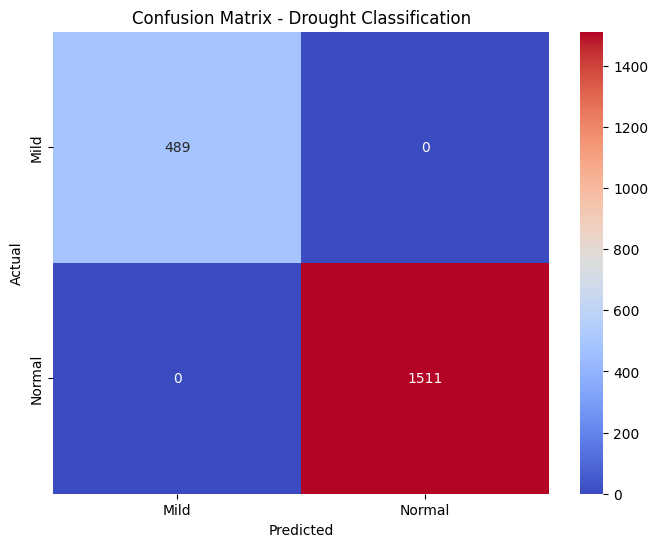

[LightGBM] [Info] Number of positive: 6045, number of negative: 1955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.755625 -> initscore=1.128841
[LightGBM] [Info] Start training from score 1.128841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

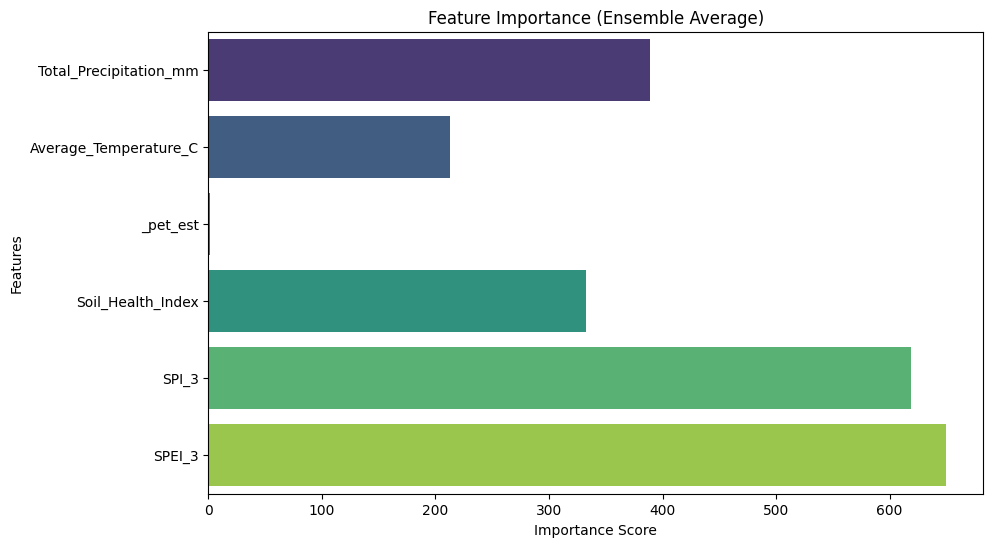

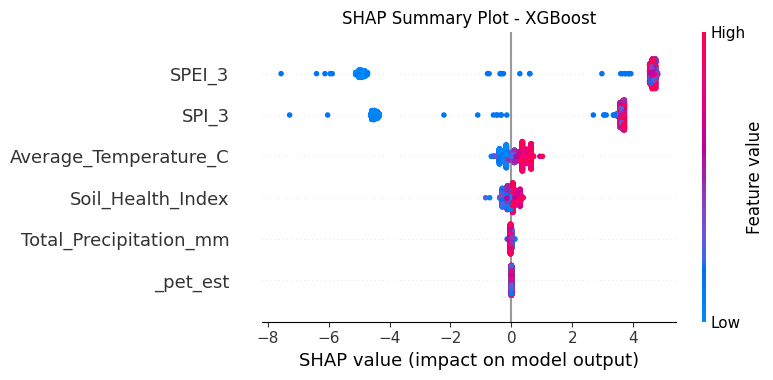

In [25]:
# ---------------------------------------------------
# 📌 Install Required Libraries
# ---------------------------------------------------
!pip install xgboost lightgbm catboost shap matplotlib seaborn scikit-learn --quiet

# ---------------------------------------------------
# 📌 Import Libraries
# ---------------------------------------------------
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------------------
# 📌 Load Dataset
# ---------------------------------------------------
DATA_PATH = "/content/climate_change_impact_on_agriculture_2024.csv"
df = pd.read_csv(DATA_PATH)
print(f"Dataset Shape: {df.shape}")
print(df.head())

# ---------------------------------------------------
# 📌 Detect Columns Dynamically
# ---------------------------------------------------
def col_like(df, patterns):
    import re
    cols = {c.lower(): c for c in df.columns}
    for p in patterns:
        rx = re.compile(p)
        for lc, orig in cols.items():
            if rx.search(lc):
                return orig
    return None

rain_col  = col_like(df, [r"rain", r"precip", r"ppt"])
temp_col  = col_like(df, [r"temp", r"temperature"])
pet_col   = col_like(df, [r"pet", r"evapo", r"et0"])
soil_col  = col_like(df, [r"soil", r"soil_health", r"moisture"])
yield_col = col_like(df, [r"yield", r"production"])

# ---------------------------------------------------
# 📌 Clean Numeric Columns
# ---------------------------------------------------
def safe_num(df, col):
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col] = df[col].fillna(df[col].median())
    return df

for c in [rain_col, temp_col, pet_col, soil_col, yield_col]:
    if c:
        df = safe_num(df, c)

# If PET missing, estimate it from temperature
if not pet_col:
    df["_pet_est"] = 0.6 * df[temp_col].fillna(0.0)
    pet_col = "_pet_est"

# ---------------------------------------------------
# 📌 Feature Engineering - SPI & SPEI
# ---------------------------------------------------
def rolling_z(arr, window=3):
    s = pd.Series(arr)
    mean = s.rolling(window, min_periods=1).mean()
    std = s.rolling(window, min_periods=1).std(ddof=0).replace(0, s.std(ddof=0))
    return ((s - mean) / (std + 1e-9)).fillna(0.0).values

df["SPI_3"] = rolling_z(df[rain_col].values, window=3)
df["SPEI_3"] = rolling_z(df[rain_col].values - df[pet_col].values, window=3)

# ---------------------------------------------------
# 📌 Create Drought Severity Labels
# ---------------------------------------------------
def drought_label(spi, spei):
    v = min(spi, spei)
    if v <= -2.0: return "Severe"
    if v <= -1.5: return "Moderate"
    if v <= -1.0: return "Mild"
    return "Normal"

df["drought_severity"] = [drought_label(a, b) for a, b in zip(df["SPI_3"], df["SPEI_3"])]

# ---------------------------------------------------
# 📌 Feature Selection
# ---------------------------------------------------
features = [rain_col, temp_col, pet_col, soil_col, "SPI_3", "SPEI_3"]
features = [f for f in features if f in df.columns]

X = df[features].values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["drought_severity"])

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# ---------------------------------------------------
# 📌 Split Data
# ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------------------------------
# 📌 Stacked Ensemble Model
# ---------------------------------------------------
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
lgbm = LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
cat = CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, verbose=0)

estimators = [
    ("xgb", xgb),
    ("lgbm", lgbm),
    ("cat", cat),
]

stacking = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500),
    cv=5,
    n_jobs=-1
)

# Train the model
stacking.fit(X_train, y_train)
y_pred = stacking.predict(X_test)

# ---------------------------------------------------
# 📌 Evaluation Metrics (Dynamic Labels)
# ---------------------------------------------------
acc = accuracy_score(y_test, y_pred)
print(f"\n🔹 Final Accuracy: {acc:.4f}")

class_labels = list(label_encoder.classes_)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_labels))

# ---------------------------------------------------
# 📌 Confusion Matrix Visualization
# ---------------------------------------------------
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Drought Classification")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ---------------------------------------------------
# 📌 Feature Importance (Average of All Models)
# ---------------------------------------------------
xgb.fit(X_train, y_train)
lgbm.fit(X_train, y_train)
cat.fit(X_train, y_train)

plt.figure(figsize=(10,6))
importance = np.mean([
    xgb.feature_importances_,
    lgbm.feature_importances_,
    cat.feature_importances_
], axis=0)

sns.barplot(x=importance, y=features, palette="viridis")
plt.title("Feature Importance (Ensemble Average)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# ---------------------------------------------------
# 📌 SHAP Explainability (XGBoost)
# ---------------------------------------------------
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

plt.title("SHAP Summary Plot - XGBoost")
shap.summary_plot(shap_values, X_test, feature_names=features)
